# [Data 102] Final Project Notebook - Asthma and Air Quality

__Group Number__: 15

__Group Members__: Andrew O'Connor, Stephanie Wong, Cole Hesterberg, Jorge Prieto

---

# Generalized Linear Model and Non-parametric Methods

### import libraries

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import statsmodels.api as sm
from scipy.stats import beta, binom, uniform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

### Data Processing

#### SOURCE: https://fortress.wa.gov/doh/wtn/WTNPortal/#!q0=887

Cleaning Washington state asthma hospitalization data

In [2]:
wa = pd.read_csv('./data/glm_data/washington_asthma_2016.csv')
wa['Count'] = pd.to_numeric(wa['Count'], errors='coerce').fillna(0).astype(int)
wa_final = wa.iloc[1:40, 0:2]
wa_final.columns = ['county', 'count']
wa_final['state'] = 'Washington'
wa_final.head()

,county,count,state
1,Adams,0,Washington
2,Asotin,0,Washington
3,Benton,65,Washington
4,Chelan,10,Washington
5,Clallam,19,Washington


#### SOURCE: https://healthdata.gov/State/Asthma-Hospitalization-Rates-by-County/p4xm-skkv/about_data

Cleaning California state asthma hospitalization data

In [3]:
ca = pd.read_csv('./data/glm_data/CA_asthma_2015_2020.csv',  encoding='latin1')
ca['NUMBER OF HOSPITALIZATIONS'] = ca['NUMBER OF HOSPITALIZATIONS'].fillna('0').str.replace(',', '').astype(int)
avg_ca = ca.groupby('COUNTY')['NUMBER OF HOSPITALIZATIONS'].mean().reset_index()
ca_final = avg_ca[avg_ca['COUNTY'] != 'California']
ca_final.columns = ['county', 'count']
ca_final.loc[:, 'count'] = ca_final['count'].round(0)
ca_final['count'] = ca_final['count'].astype(int)
ca_final['state'] = 'California'
ca_final.head()

,county,count,state
0,Alameda,257,California
1,Alpine,0,California
2,Amador,2,California
3,Butte,29,California
4,Calaveras,2,California


#### SOURCE: https://www.flhealthcharts.gov/ChartsDashboards/rdPage.aspx?rdReport=NonVitalInd.Dataviewer&cid=9755

Cleaning Florida state asthma hospitalization data

In [4]:
fl = pd.read_csv('./data/glm_data/florida_2016.csv')
fl.columns = fl.iloc[0]
fl = fl[1:]
fl['Count'] = fl['Count'].fillna('0').str.replace(',', '').astype(int)
fl_final = fl.iloc[1:, 0:2]
fl_final.columns = ['county', 'count']
fl_final['state'] = 'Florida'
fl_final.head()

,county,count,state
2,Alachua,299,Florida
3,Baker,21,Florida
4,Bay,98,Florida
5,Bradford,19,Florida
6,Brevard,281,Florida


#### SOURCE: https://iquery.illinois.gov/DataQuery/default.aspx

Cleaning Illinois state asthma hospitalization data

In [5]:
il = pd.read_csv('./data/glm_data/illinois_hosp.csv')
il_filt = il[il['Age Range'] == 'ALL']

#1-10s were converted to 0
il_filt.loc[:, 'Count'] = pd.to_numeric(il_filt['Count'], errors='coerce').fillna(0).astype(int)
il_filt = il_filt.groupby('Area')['Count'].mean().reset_index()
il_final = il_filt[il_filt['Area'] != 'Illinois']
il_final.loc[:, 'Count'] = il_final['Count'].astype(int)
il_final.columns = ['county', 'count']
il_final['state'] = 'Illinois'
il_final.head()

,county,count,state
0,Adams,615,Illinois
1,Alexander,0,Illinois
2,Bond,75,Illinois
3,Boone,413,Illinois
4,Brown,41,Illinois


#### SOURCE: https://www.health.ny.gov/statistics/environmental/public_health_tracking/about_pages/asthma/export

Cleaning New York state asthma hospitalization data

In [6]:
ny = pd.read_csv('./data/glm_data/NewYork_Data.csv')
ny_hosp = ny[ny['indicator']=='Hospitalizations']
ny_final = ny_hosp.groupby('County')['count'].mean().reset_index().round(0)
ny_final.columns = ['county', 'count']
ny_final['count'] = ny_final['count'].astype(int)
ny_final['state'] = 'New York'
dfs = [ny_final, il_final, fl_final, ca_final, wa_final]

hosp_df = pd.concat(dfs, ignore_index=True)
hosp_df

hosp_df.to_csv('data/hosp_counts.csv', index=False)

#### SOURCE: https://www.socialexplorer.com/tables/SLDR2020

Cleaning demographic data (race) from Social Explorer for the year 2022.

In [7]:
dem = pd.read_csv('./data/glm_data/counties_dem_2022.csv')
dem = dem.dropna(axis=1, how='all')

column_mapping = {
    'SE_T006_001': 'white',
    'SE_T006_002': 'black',
    'SE_T006_003': 'asian',
    'SE_T006_004': 'indigenous',
    'SE_T006_005': 'other',
    'SE_T006_006': 'multiracial',
}

dem = dem.rename(columns=column_mapping)
dem['Geo_NAME'] = dem['Geo_NAME'].str.replace(' County', '')
dem['Geo_QNAME'] = dem['Geo_QNAME'].str.split(', ').str[-1]
dem_2022 = dem.loc[:, ['Geo_NAME', 'Geo_QNAME', 'white', 'black', 'asian', 'indigenous', 'other', 'multiracial']]
dem_2022.columns= ['county', 'state', 'white', 'black', 'asian', 'indigenous', 'other', 'multiracial']
dem_2022.head()

,county,state,white,black,asian,indigenous,other,multiracial
0,Alameda,California,515035,161456,547026,19264,217142,186660
1,Alpine,California,836,10,12,237,13,122
2,Amador,California,31861,1236,677,776,2860,3992
3,Butte,California,147546,3620,10900,4468,17709,24574
4,Calaveras,California,37649,373,870,770,2048,5150


Merging hospitalization data with the demographic dataset for race

In [8]:
hosp_dem = pd.merge(hosp_df, dem_2022, on=['state', 'county'], how='inner')
hosp_dem.head()

,county,count,state,white,black,asian,indigenous,other,multiracial
0,Albany,1245,New York,212908,42554,24254,844,8839,21213
1,Allegany,170,New York,42183,817,383,91,676,1908
2,Bronx,31338,New York,196279,460548,68117,20533,472721,181439
3,Broome,692,New York,155742,12409,9235,554,3895,12856
4,Cattaraugus,263,New York,67454,1037,575,2685,568,3952


#### SOURCE: https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2011/fcqm-xrf4/about_data

Cleaning PM2.5 Daily Concentration data

In [9]:
pm25 = pd.read_csv('./data/glm_data/pm25_2011_2014.csv')
pm25.head()

,countyfips,ds_pm_pred
0,12001,7.693598
1,12003,7.764423
2,12005,8.376431
3,12007,7.551175
4,12009,6.407826


#### SOURCE: https://github.com/kjhealy/fips-codes/blob/master/state_and_county_fips_master.csv

##### Using fips codes to merge PM2.5 and ozone data sets to match data to respective counties.

In [10]:
pm25 = pd.read_csv('./data/glm_data/pm25_2011_2014.csv')
fips = pd.read_csv('./data/glm_data/fips_all.csv')

pm25_pt1 = pd.merge(pm25, fips, left_on='countyfips', right_on='fips', how='left')
pm25_pt1.head()

,countyfips,ds_pm_pred,fips,name,state
0,12001,7.693598,12001,Alachua County,FL
1,12003,7.764423,12003,Baker County,FL
2,12005,8.376431,12005,Bay County,FL
3,12007,7.551175,12007,Bradford County,FL
4,12009,6.407826,12009,Brevard County,FL


#### SOURCE: https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-Ozone-Concentrations-2011/372p-dx3h/about_data

Cleaning ozone daily CDC data

In [11]:
ozone = pd.read_csv('./data/glm_data/ozone_2011_2014.csv')
oz_pm = pd.merge(pm25_pt1, ozone, on='countyfips', how='inner')
oz_pm['name'] = oz_pm['name'].str.replace(' County', '')
state_mapping = {
    'NY': 'New York',
    'WA': 'Washington',
    'CA': 'California',
    'IL': 'Illinois',
    'FL': 'Florida',
}
oz_pm['state'] = oz_pm['state'].map(state_mapping)
oz_pm = oz_pm.rename(columns={'name': 'county'})

Merging race data and ozone with PM2.5 data

In [12]:
full = pd.merge(oz_pm, hosp_dem, on = ['state', 'county'])
full = full.rename(columns={'count': 'hosp_count'})
full['pop'] = full[['white', 'black', 'asian', 'indigenous', 'other', 'multiracial']].sum(axis=1)

full['white_prop'] = full['white'] / full['pop']
full['black_prop'] = full['black'] / full['pop']
full['asian_prop'] = full['asian'] / full['pop']
full['indigenous_prop'] = full['indigenous'] / full['pop']
full['other_prop'] = full['other'] / full['pop']
full['multiracial_prop'] = full['multiracial'] / full['pop']

full_filt = full.loc[:, ['county', 'state', 'ds_o3_pred', 'ds_pm_pred', 'hosp_count', 'white_prop', 'black_prop', 'asian_prop', 'indigenous_prop', 'other_prop', 'multiracial_prop', 'pop']]
full_filt.head()

# full_filt.to_csv('full.csv', index=False)

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop
0,Alachua,Florida,36.508214,7.693598,299,0.613028,0.186577,0.064998,0.003048,0.033973,0.098375,278576
1,Baker,Florida,36.660481,7.764423,21,0.798461,0.136473,0.006001,0.004340,0.015868,0.038857,29493
2,Bay,Florida,38.427998,8.376431,98,0.750248,0.101211,0.024607,0.005843,0.030193,0.087898,178321
3,Bradford,Florida,36.882157,7.551175,19,0.742198,0.190572,0.005542,0.002667,0.017180,0.041841,28871
4,Brevard,Florida,38.787787,6.407826,281,0.738158,0.098238,0.027283,0.003719,0.033066,0.099536,622701


#### SOURCE: https://www.socialexplorer.com/tables/SLDR2020

##### Cleaning household income data for 2022 from Social Explorer

In [13]:
income = pd.read_csv('./data/glm_data/income_redone.csv')
income = income.dropna(axis=1, how='all')

rename_dict = {
    'SE_T016_001': 'Household Income, Median',
    'SE_T016_002': 'lt_25k',
    'SE_T016_003': '25k_35k',
    'SE_T016_004': '35k_50k',
    'SE_T016_005': '50k_75k',
    'SE_T016_006': '75k_100k',
    'SE_T016_007': '100k_125k',
    'SE_T016_008': 'gt_125k'
}

income = income.rename(columns=rename_dict)
income['county'] = income['Geo_NAME'].str.replace(' County', '')
income['state'] = income['Geo_QNAME'].str.split(', ').str[-1]

income_int = income.loc[:, ['county', 'state', 'lt_25k', '25k_35k', '35k_50k', '50k_75k', '75k_100k', '100k_125k', 'gt_125k']]
income_int['pop_inc'] = income_int[['lt_25k', '25k_35k', '35k_50k', '50k_75k', '75k_100k', '100k_125k', 'gt_125k']].sum(axis=1)

income_int['lt_25k_prop'] = income_int['lt_25k'] / income_int['pop_inc']
income_int['25k_35k_prop'] = income_int['25k_35k'] / income_int['pop_inc']
income_int['35k_50k_prop'] = income_int['35k_50k'] / income_int['pop_inc']
income_int['50k_75k_prop'] = income_int['50k_75k'] / income_int['pop_inc']
income_int['75k_100k_prop'] = income_int['75k_100k'] / income_int['pop_inc']
income_int['100k_125k_prop'] = income_int['100k_125k'] / income_int['pop_inc']
income_int['gt_125k_prop'] = income_int['gt_125k'] / income_int['pop_inc']


filtered_income_int = income_int[['county', 'state', 'lt_25k_prop', '25k_35k_prop', '35k_50k_prop', '50k_75k_prop', '75k_100k_prop', '100k_125k_prop', 'gt_125k_prop']]
filtered_income_int.head()

,county,state,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop
0,Alameda,California,0.115191,0.049011,0.066908,0.112500,0.108330,0.094477,0.453583
1,Alpine,California,0.101887,0.107547,0.079245,0.150943,0.115094,0.109434,0.335849
2,Amador,California,0.158383,0.093210,0.105437,0.167994,0.140469,0.107143,0.227366
3,Butte,California,0.222313,0.100083,0.118596,0.157351,0.113068,0.085511,0.203078
4,Calaveras,California,0.145809,0.087894,0.111747,0.163388,0.140630,0.107863,0.242667


Merging income data with other large merged table to produce the final dataframe

In [14]:
full_data = pd.merge(full_filt, filtered_income_int, on=['county', 'state'], how='inner')
full_data.head()

# full_data.to_csv('full_data.csv', index=False)

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop
0,Alachua,Florida,36.508214,7.693598,299,0.613028,0.186577,0.064998,0.003048,0.033973,0.098375,278576,0.259452,0.085891,0.120081,0.167524,0.112596,0.074477,0.179979
1,Baker,Florida,36.660481,7.764423,21,0.798461,0.136473,0.006001,0.004340,0.015868,0.038857,29493,0.145195,0.077548,0.130915,0.198979,0.153117,0.099124,0.195122
2,Bay,Florida,38.427998,8.376431,98,0.750248,0.101211,0.024607,0.005843,0.030193,0.087898,178321,0.166087,0.082836,0.134614,0.198470,0.147200,0.093537,0.177256
3,Bradford,Florida,36.882157,7.551175,19,0.742198,0.190572,0.005542,0.002667,0.017180,0.041841,28871,0.259221,0.082684,0.145628,0.202944,0.118355,0.079221,0.111948
4,Brevard,Florida,38.787787,6.407826,281,0.738158,0.098238,0.027283,0.003719,0.033066,0.099536,622701,0.166635,0.086666,0.126523,0.182575,0.132545,0.095496,0.209559


---

### Research Question
What factors impact asthma hospitalizations most greatly in the United States? How can we predict asthma hospitalizations based on demographic (socioeconomic and racial) data and environmental data such as PM2.5 and ozone levels?

### GLM (Frequentist)

In [15]:
df = pd.read_csv('./data/glm_data/full_data.csv')
df.head()

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop
0,Alachua,Florida,36.508214,7.693598,299,0.613028,0.186577,0.064998,0.003048,0.033973,0.098375,278576,0.259452,0.085891,0.120081,0.167524,0.112596,0.074477,0.179979
1,Baker,Florida,36.660481,7.764423,21,0.798461,0.136473,0.006001,0.004340,0.015868,0.038857,29493,0.145195,0.077548,0.130915,0.198979,0.153117,0.099124,0.195122
2,Bay,Florida,38.427998,8.376431,98,0.750248,0.101211,0.024607,0.005843,0.030193,0.087898,178321,0.166087,0.082836,0.134614,0.198470,0.147200,0.093537,0.177256
3,Bradford,Florida,36.882157,7.551175,19,0.742198,0.190572,0.005542,0.002667,0.017180,0.041841,28871,0.259221,0.082684,0.145628,0.202944,0.118355,0.079221,0.111948
4,Brevard,Florida,38.787787,6.407826,281,0.738158,0.098238,0.027283,0.003719,0.033066,0.099536,622701,0.166635,0.086666,0.126523,0.182575,0.132545,0.095496,0.209559


In [16]:
features = ['white_prop', 'black_prop', 'asian_prop', 'indigenous_prop', 'other_prop', 'multiracial_prop', 'pop', 'lt_25k_prop', '25k_35k_prop', '35k_50k_prop', '50k_75k_prop', '75k_100k_prop', '100k_125k_prop', 'gt_125k_prop', 'ds_o3_pred', 'ds_pm_pred']
target = 'hosp_count'

<Figure size 1500x1000 with 0 Axes>

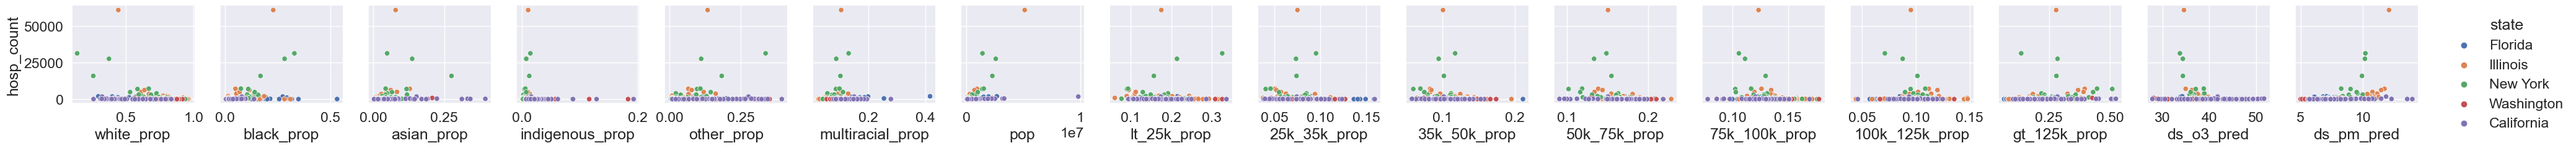

In [17]:
sns.set(font_scale=1.5);  # Set font scale to 1.5
plt.figure(figsize=(15, 10));  # Set the figure size to 15x10 inches
sns.pairplot(df, x_vars=features, y_vars=[target], hue='state')
# plt.savefig('pairplot.png')  # uncomment to save plot as PNG file
plt.show()

### Poisson GLM

In [18]:
pois_model = sm.GLM(
    df.hosp_count, sm.add_constant(df[features]),
    family=sm.families.Poisson()
)
pois_results = pois_model.fit()
print(pois_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             hosp_count   No. Observations:                  320
Model:                            GLM   Df Residuals:                      305
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0502e+05
Date:                Mon, 06 May 2024   Deviance:                   2.0813e+05
Time:                        22:44:31   Pearson chi2:                 3.51e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.6915      0.122  

### Negative Binomial GLM

In [19]:
negbin_model = sm.GLM(
    df.hosp_count, sm.add_constant(df[features]),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             hosp_count   No. Observations:                  320
Model:                            GLM   Df Residuals:                      305
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1976.5
Date:                Mon, 06 May 2024   Deviance:                       615.01
Time:                        22:44:31   Pearson chi2:                     446.
No. Iterations:                    59   Pseudo R-squ. (CS):             0.9542
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6888      0.797  

In [20]:
print("Poisson Model AIC:", pois_results.aic)
print("Negative Binomial Model AIC:", negbin_results.aic)

Poisson Model AIC: 210071.0234799576
Negative Binomial Model AIC: 3982.957863300161


### GLM Results

The negative binomial model has a much lower AIC, so this will be the model we select out of our frequentist GLMs that work ideally on predicting counts.

---

# Non-Parametric Methods

### Random Forest

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

train, test = train_test_split(df, test_size=0.3,random_state=1027)

forest_model = RandomForestRegressor(max_features=1)
forest_model.fit(train[features], train[target])

feature_importances = forest_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
for i in sorted_indices:
    print(f"{features[i]}: {feature_importances[i]}")

train["forest_pred"] = forest_model.predict(train[features])
test["forest_pred"] = forest_model.predict(test[features])

pop: 0.1562362738923689
black_prop: 0.1028154376550329
white_prop: 0.09621965319810066
ds_pm_pred: 0.08990250991898166
ds_o3_pred: 0.058429467467511105
75k_100k_prop: 0.05771851805109992
50k_75k_prop: 0.05569543579562565
35k_50k_prop: 0.05103493509726857
other_prop: 0.04918744106550772
asian_prop: 0.04769782854226538
lt_25k_prop: 0.044535899158864266
indigenous_prop: 0.04422747769045302
multiracial_prop: 0.038066227695628445
100k_125k_prop: 0.03762490363439391
gt_125k_prop: 0.03584844750871817
25k_35k_prop: 0.03475954362817965


In [22]:
test.head()

,county,state,ds_o3_pred,ds_pm_pred,hosp_count,white_prop,black_prop,asian_prop,indigenous_prop,other_prop,multiracial_prop,pop,lt_25k_prop,25k_35k_prop,35k_50k_prop,50k_75k_prop,75k_100k_prop,100k_125k_prop,gt_125k_prop,forest_pred
298,San Diego,California,40.987241,9.876479,408,0.493678,0.047017,0.129015,0.012376,0.159496,0.158417,3306465,0.127485,0.062548,0.092259,0.149279,0.127081,0.103867,0.337480,3981.37
234,Garfield,Washington,38.342310,6.514741,0,0.919321,0.003822,0.004671,0.007643,0.011890,0.052654,2355,0.115596,0.108257,0.174312,0.204587,0.177982,0.110092,0.109174,92.11
228,Clark,Washington,30.168462,8.117319,96,0.753899,0.022542,0.058697,0.009578,0.051144,0.104140,511676,0.107227,0.059639,0.104032,0.173375,0.142871,0.116765,0.296091,550.97
266,Calaveras,California,45.197574,7.426730,2,0.803436,0.007960,0.018566,0.016432,0.043705,0.109902,46860,0.145809,0.087894,0.111747,0.163388,0.140630,0.107863,0.242667,85.84
189,Madison,New York,36.820449,7.818533,227,0.905456,0.016241,0.010000,0.006851,0.007489,0.053963,68899,0.164438,0.080677,0.118075,0.178601,0.139912,0.113163,0.205135,288.79


In [23]:
train_rmse = np.mean((train["forest_pred"] - train["hosp_count"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["hosp_count"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:", test_rmse)

Training set error for random forest: 1671.0848764205064
Test set error for random forest: 1068.978792207096


### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()

tree_model.fit(train[features], train["hosp_count"])

feature_importances = tree_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

for i in sorted_indices:
    print(f"{features[i]}: {feature_importances[i]}")

train["tree_pred"] = tree_model.predict(train[features])
test["tree_pred"] = tree_model.predict(test[features])

pop: 0.42937538958273375
100k_125k_prop: 0.3317918210280003
white_prop: 0.18588050380769108
multiracial_prop: 0.021138829025808797
lt_25k_prop: 0.01324102104242002
50k_75k_prop: 0.006640512426840242
ds_pm_pred: 0.005815293854093512
gt_125k_prop: 0.002914534181344498
black_prop: 0.0021319217542373
asian_prop: 0.0005650797725547586
ds_o3_pred: 0.00036186968258387323
indigenous_prop: 9.262335806814145e-05
other_prop: 3.44107770341646e-05
75k_100k_prop: 8.669525218546836e-06
25k_35k_prop: 5.906914468078141e-06
35k_50k_prop: 1.613266902973974e-06


In [25]:
train_rmse = np.mean((train["tree_pred"] - train["hosp_count"]) ** 2) ** 0.5
test_rmse = np.mean((test["tree_pred"] - test["hosp_count"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree: 8790.991637395067


In [26]:
test['glm_predict'] = negbin_results.predict(sm.add_constant(test[features]))
test_rmse = np.mean((test["glm_predict"] - test["hosp_count"]) ** 2) ** 0.5


print("Test set error for GLM:", test_rmse)

Test set error for GLM: 1226.3966554333824


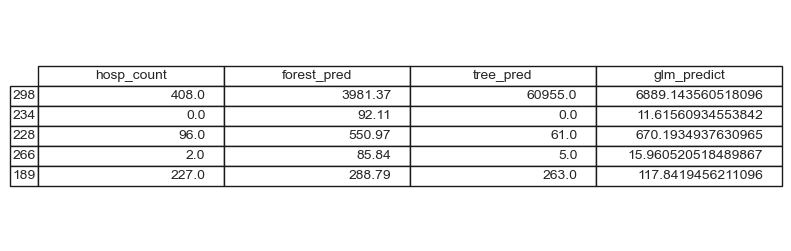

In [27]:
from pandas.plotting import table

test1 = test.loc[:, ['hosp_count', 'forest_pred', 'tree_pred', 'glm_predict']].head()

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
tbl = table(ax, test1.loc[:, ['hosp_count', 'forest_pred', 'tree_pred', 'glm_predict']].head(), loc='center')
tbl.auto_set_font_size(False);
tbl.set_fontsize(10);
tbl.scale(1.2, 1.2);

# Save the figure as PNG
#plt.savefig('dataframe_table1.png', bbox_inches='tight')
plt.show()

<br>

---

# Bayesian Hierarchical Model

### import libraries

In [28]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import beta, binom, uniform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

### data processing

datasets used: `pm25_county_averages.csv`, `oz_county_averages`,`ca_county_fips.csv`, `county_prevalences.csv`, `ed_visit.csv`, `ca_county_pop.csv`

__PM 2.5 Data__ + __FIPS data__

County PM 2.5 concentratioons between the years 2011 - 2014; FIPS codes for all CA counties

In [29]:
pm_data = pd.read_csv('./data/bhm_data/pm25_county_averages.csv')
pm_data = pm_data.drop(columns='Unnamed: 0')

county_fips = pd.read_csv('./data/bhm_data/ca_county_fips.csv')
county_fips = county_fips.rename(columns={'County Name': 'county_name',
                                          'FIPS County Code': 'fips_county_code'})
county_fips['fips_county_code'] = 6000 + county_fips['fips_county_code']
county_fips['county_name'] = county_fips['county_name'].str.title()

pm_data = pd.merge(county_fips, pm_data, left_on='fips_county_code', right_on='countyfips')
pm_data = pm_data.drop(columns='countyfips')

<br>

__Ozone Data__ + __FIPS data__

County Ozone concentratioons between the years 2011 - 2014; FIPS codes for all CA counties

In [30]:
oz_data = pd.read_csv('./data/bhm_data/oz_county_averages.csv')

county_fips = pd.read_csv('./data/bhm_data/ca_county_fips.csv')
county_fips = county_fips.rename(columns={'County Name': 'county_name',
                                          'FIPS County Code': 'fips_county_code'})
county_fips['fips_county_code'] = 6000 + county_fips['fips_county_code']
county_fips['county_name'] = county_fips['county_name'].str.title()

oz_data = pd.merge(county_fips, oz_data, left_on='fips_county_code', right_on='countyfips')
oz_data = oz_data.drop(columns=['countyfips','Unnamed: 0'])

<br>

__Asthma Prevalence Data__

County asthma prevalence in adults between the years 2015 - 2019

In [31]:
county_prevalences = pd.read_csv('./data/bhm_data/county_prevalences.csv')

strata = county_prevalences['STRATA'] == 'Child vs. adult'
agegroup = county_prevalences['AGE GROUP'] == '18+ years'


county_prevalences = county_prevalences[strata & agegroup]
county_prevalences = county_prevalences[['COUNTY', 'YEARS', 'AGE GROUP', 'CURRENT PREVALENCE', 'COUNTIES GROUPED']]
county_prevalences = county_prevalences.rename(columns={'COUNTY': 'county',
                                                'YEARS':'years',
                                                'AGE GROUP': 'age_group',
                                                'CURRENT PREVALENCE':'current_asthma_prevalence',
                                                'COUNTIES GROUPED':'counties_grouped'})
county_prevalences['years'] = county_prevalences['years'].str.extract(r'^(\d{4})')
county_prevalences = county_prevalences.rename(columns={'years':'year'})

<br>

__County Population Data__

County population average over the years 2015 - 2019

In [32]:
county_populations = pd.read_csv('./data/bhm_data/ca_county_pop.csv')
county_populations['county'] = county_populations['County, California'].str.extract(r'.(.+) County,')
county_populations = county_populations.replace(to_replace='[,.]', value='', regex=True)

years = ['2015', '2016', '2017', '2018', '2019']
for year in years:
    county_populations[year] = pd.to_numeric(county_populations[year], errors='coerce')

county_populations['avg_population'] = county_populations[years].mean(axis=1)
county_populations = county_populations[['county', 'avg_population']]

<br>

__Asthma ED Department Visits__

In [33]:
ed_visits = pd.read_csv('./data/bhm_data/ed_visits.csv')
ed_visits = ed_visits.drop(columns='Unnamed: 0')

ed_visits = ed_visits.rename(columns={'COUNTY':'county', 
                                      'NUMBER OF ED VISITS':'num_ed_visits'})

<br>

__Full Dataset (PM 2.5 Data + Ozone Data + County Asthma Prevalences + County ED Visits + County Population Data)__

Note: This merge ignores the year as part of the analysis.

In [34]:
# average PM2.5 data by county
pm_data_avg = pm_data.groupby('county_name').mean()
pm_data_avg = pm_data_avg.drop(columns=['fips_county_code', 'year'])

# average ozone data by county
oz_data_avg = oz_data.groupby('county_name').mean()
oz_data_avg = oz_data_avg.drop(columns=['fips_county_code', 'year'])

# average population data by county
county_prevalences_avg = county_prevalences[['county', 'current_asthma_prevalence']].groupby('county').mean()

# merge the datasets
pm_asthma_merge = county_prevalences_avg.merge(pm_data_avg, left_on='county', right_on='county_name', right_index=True).reset_index()
full_dataset = pm_asthma_merge.merge(oz_data_avg, left_on='county', right_on='county_name')
full_dataset = full_dataset.merge(county_populations, left_on='county', right_on='county')
full_dataset = full_dataset.merge(ed_visits, left_on='county', right_on='county')

# create Asthma population feature
full_dataset['asthma_pop'] = full_dataset['current_asthma_prevalence'] * full_dataset['avg_population']

# standardize PM2.5 and ozone values
full_dataset['avg_pm_pred'] = (full_dataset['avg_pm_pred'] - full_dataset['avg_pm_pred'].mean()) / full_dataset['avg_pm_pred'].std()
full_dataset['avg_oz_pred'] = (full_dataset['avg_oz_pred'] - full_dataset['avg_oz_pred'].mean()) / full_dataset['avg_oz_pred'].std()

---

### EDA

In [35]:
full_dataset.head()

,county,current_asthma_prevalence,avg_pm_pred,avg_pm_stdd,avg_oz_pred,avg_oz_stdd,avg_population,num_ed_visits,asthma_pop
0,Alameda,0.079366,0.554731,3.666390,-1.640447,3.554561,1656753.8,2286.275,131489.369840
1,Alpine,0.118609,-1.236126,2.719278,0.908246,5.765540,1090.6,0.000,129.355339
2,Amador,0.118609,-0.383043,3.171970,0.585539,4.739160,38429.2,46.350,4558.061793
3,Butte,0.110100,-0.230812,3.071070,0.331791,4.600848,225816.6,236.325,24862.482932
4,Calaveras,0.118609,-0.452196,3.209525,0.687751,4.931879,45514.2,49.975,5398.408919


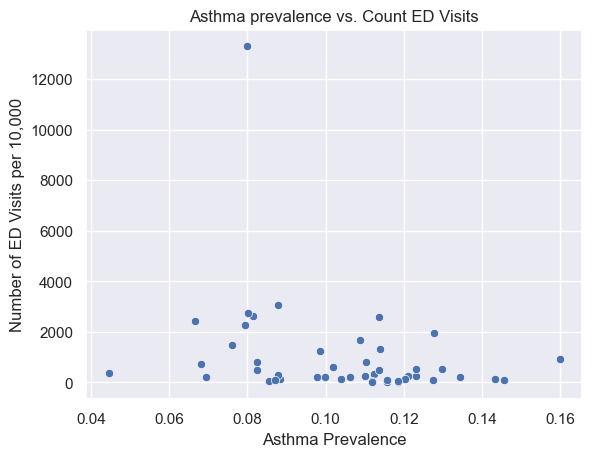

In [36]:
sns.scatterplot(x=full_dataset['current_asthma_prevalence'], y=full_dataset['num_ed_visits']);
plt.title('Asthma prevalence vs. Count ED Visits');
plt.ylabel('Number of ED Visits per 10,000');
plt.xlabel('Asthma Prevalence');

In [37]:
full_dataset[full_dataset['num_ed_visits'] == full_dataset['num_ed_visits'].max()]

,county,current_asthma_prevalence,avg_pm_pred,avg_pm_stdd,avg_oz_pred,avg_oz_stdd,avg_population,num_ed_visits,asthma_pop
18,Los Angeles,0.080034,1.684906,3.859547,0.15517,4.174196,10081569.6,13284.825,806871.70189


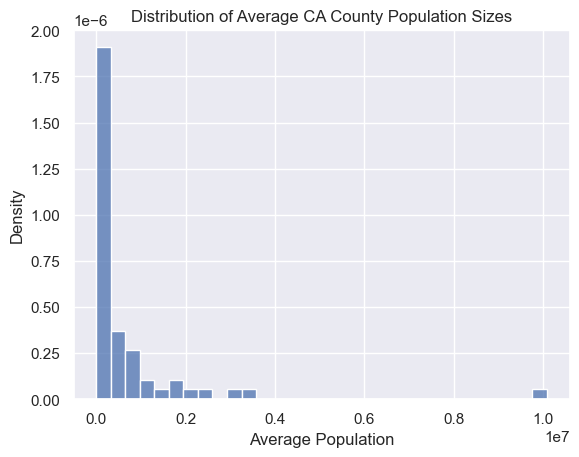

In [38]:
sns.histplot(full_dataset['avg_population'], stat='density');
plt.xlabel('Average Population');
plt.title('Distribution of Average CA County Population Sizes');

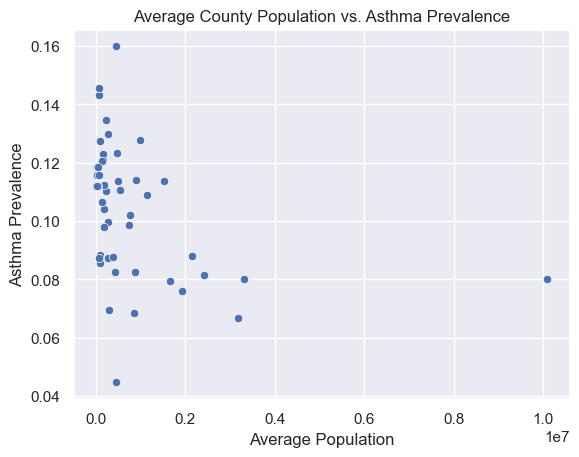

In [39]:
sns.scatterplot(x=full_dataset['avg_population'], y=full_dataset['current_asthma_prevalence']);
plt.title('Average County Population vs. Asthma Prevalence');
plt.xlabel('Average Population');
plt.ylabel('Asthma Prevalence');

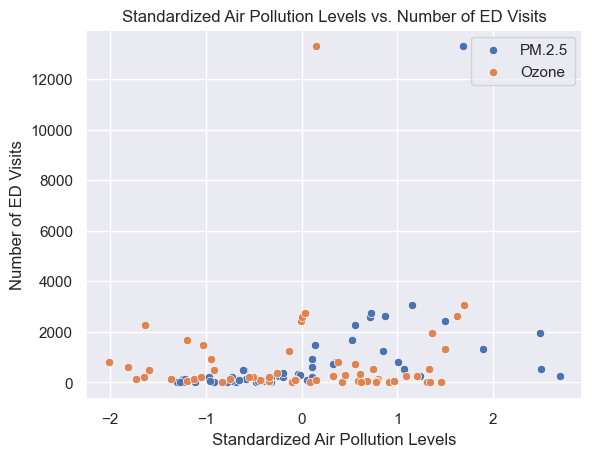

In [40]:
sns.scatterplot(x=full_dataset['avg_pm_pred'], y=full_dataset['num_ed_visits'], label='PM.2.5');
sns.scatterplot(x=full_dataset['avg_oz_pred'], y=full_dataset['num_ed_visits'], label='Ozone');
plt.title('Standardized Air Pollution Levels vs. Number of ED Visits');
plt.xlabel('Standardized Air Pollution Levels');
plt.ylabel('Number of ED Visits');

# synergenistic effects?

---

### Defining the Model

__Main Research question:__ Can we estimate the impact of PM2.5 and ozone levels on emergency department (ED) visits for asthma-related issues in California counties, based on prior distributions assigned to the model coefficients (uniform for intercept, PM2.5, and ozone effects)?

- The likelihood of observing a specific number of ED visits in a county given these environmental factors is modeled using a binomial distribution, which quantifies the response to changes in PM2.5 and ozone within a logistic regression framework

<div style="text-align: center;">
  <img src="images/graphical_model.jpg" width="500"/>
</div>

$$\beta_0, \beta_1, \beta_2  \sim \text{Uniform}(-\infty,\infty)$$

$$\theta_i = \sigma(\beta_0 + \beta_1P_i + \beta_2 O_i)$$

$$ X_i \sim \textrm{Binomial}(A_i,\theta_i)$$

### Variables

- $X_i$: The number of people in county $i$ that visit the emergency department ED
- $A_i$: The number of people in county $i$ that have asthma
- $\theta_i$: The probability that an individual with asthma in county $i$ will visit the ED (based on PM2.5 and ozone concentrations)
- $P_i$: The average PM2.5 concentration in county $i$
- $O_i$: The average ozone concentration in county $i$

### Justifying priors

Priors that need to be determined
- $\beta_0$: Intercept
- $\beta_1$: Weight on the County Average PM2.5 Prediction 
- $\beta_2$: Weight on the County Average Ozone Prediction

<br>

Justifications
- $\beta_0$: We have no prior knowledge regarding the intercept. Since it may be any real-valued number, we decided to use a Uniform(-inf, inf) prior, using pm.Flat() in pymc
- $\beta_1$: We do not know the effect of PM2.5 on ED visit rates. Therefore, we used the same uninformative prior Uniform(-inf, inf).
- $\beta_2$: We do not know the effect of Ozone on ED visit rates. Therefore, we used the same uninformative prior Uniform(-inf, inf).

<br>

### creating the model

In [41]:
with pm.Model() as model:
    # priors for regression coefficients
    intercept = pm.Flat('intercept')
    pm_25_coeff = pm.Flat('pm_25_coeff')
    ozone_coeff = pm.Flat('ozone_coeff')

    # covariates of linear predictor
    P = full_dataset['avg_pm_pred']
    O = full_dataset['avg_oz_pred']

    linear_pred = intercept + (pm_25_coeff * P) + (ozone_coeff * O)
    theta_i = pm.Deterministic('theta_i', pm.math.sigmoid(linear_pred))

    # binomial likelihood for the observed counts
    A_i = pm.Binomial('A_i',
                      n = full_dataset['asthma_pop'],
                      p = theta_i,
                      observed = full_dataset['num_ed_visits'])

    # sample from the posterior
    trace = pm.sample(2000, tune=2000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, pm_25_coeff, ozone_coeff]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


---

### Analyzing Random Parameters

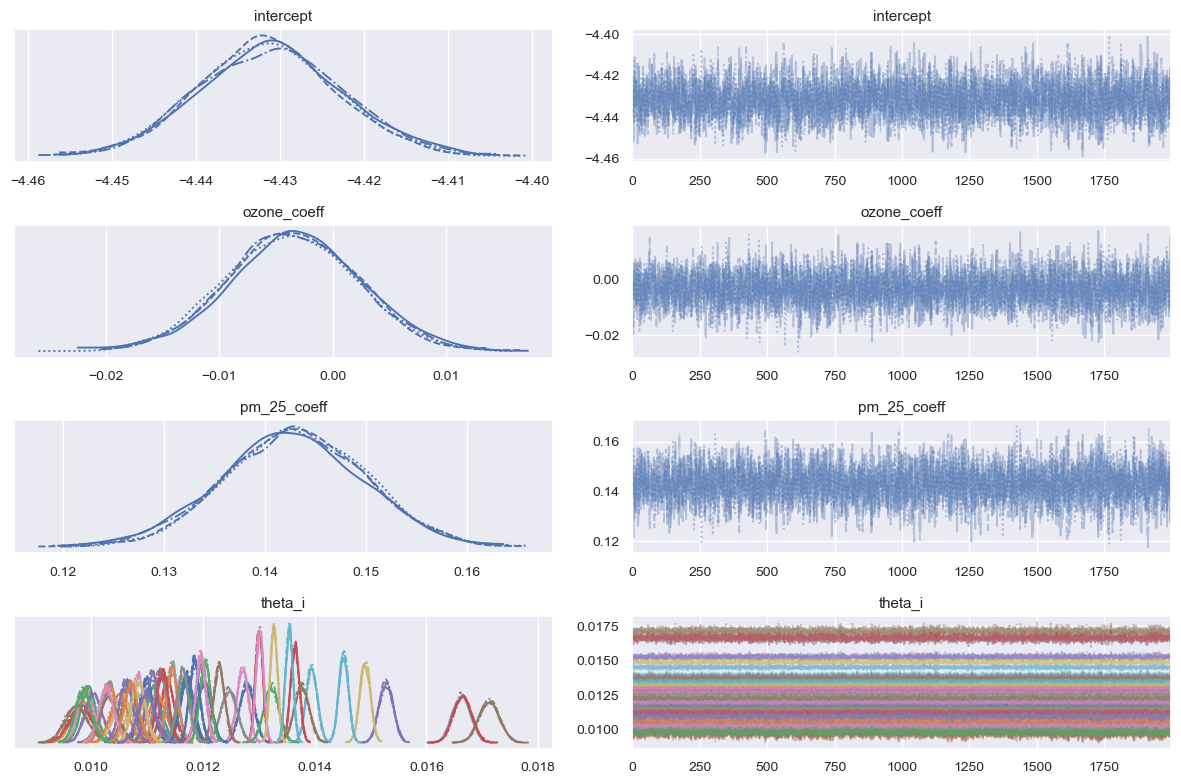

In [42]:
az.plot_trace(trace);
plt.tight_layout();

In [43]:
# az.plot_posterior(trace);

---

### Visualizing Expected ED visit rates vs. Predicted ED visit rates

In [44]:
full_dataset.head()

,county,current_asthma_prevalence,avg_pm_pred,avg_pm_stdd,avg_oz_pred,avg_oz_stdd,avg_population,num_ed_visits,asthma_pop
0,Alameda,0.079366,0.554731,3.666390,-1.640447,3.554561,1656753.8,2286.275,131489.369840
1,Alpine,0.118609,-1.236126,2.719278,0.908246,5.765540,1090.6,0.000,129.355339
2,Amador,0.118609,-0.383043,3.171970,0.585539,4.739160,38429.2,46.350,4558.061793
3,Butte,0.110100,-0.230812,3.071070,0.331791,4.600848,225816.6,236.325,24862.482932
4,Calaveras,0.118609,-0.452196,3.209525,0.687751,4.931879,45514.2,49.975,5398.408919


In [45]:
# random parameter means
posterior_mean_intercept = az.summary(trace, var_names=['intercept'])['mean'].values[0]
posterior_mean_pm_25_coeff = az.summary(trace, var_names=['pm_25_coeff'])['mean'].values[0]
posterior_mean_ozone_coeff = az.summary(trace, var_names=['ozone_coeff'])['mean'].values[0]

# probability of ed visit per row
predictor = posterior_mean_intercept + (posterior_mean_pm_25_coeff * full_dataset['avg_pm_pred']) + (posterior_mean_ozone_coeff * full_dataset['avg_oz_pred'])
prob_ed_visit = 1 / (1 + np.exp(-predictor))

# add new features to dataset
full_dataset['predicted_num_ed_visits'] = full_dataset['asthma_pop'] * prob_ed_visit
full_dataset['ed_visit_rate'] = full_dataset['num_ed_visits'] / full_dataset['avg_population']
full_dataset['predicted_ed_visit_rate'] = full_dataset['predicted_num_ed_visits'] / full_dataset['avg_population']

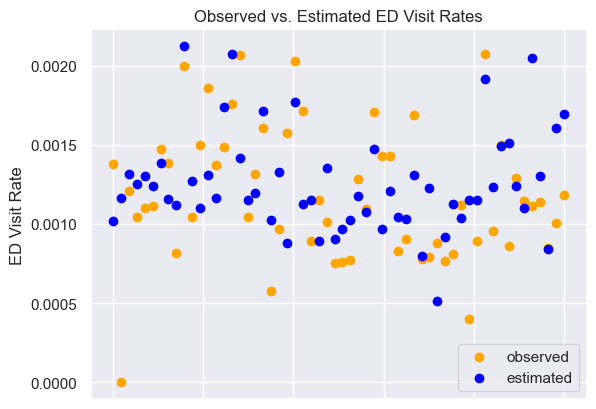

In [46]:
x = np.linspace(0, 1, len(full_dataset['county']))

plt.scatter(x=x,
            y=full_dataset['ed_visit_rate'],
            color='orange',
            label='observed');
plt.scatter(x=x,
            y=full_dataset['predicted_ed_visit_rate'],
            color='blue',
            label='estimated');
plt.legend();
plt.title('Observed vs. Estimated ED Visit Rates');
plt.xticks(visible=False);
plt.ylabel('ED Visit Rate');

### Analyze Effect of PM2.5 and ozone on Asthma

Specifically looking at the intercept and coefficients of PM2.5 and ozone

In [47]:
az.summary(trace, var_names=['intercept', 'pm_25_coeff', 'ozone_coeff'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-4.431,0.008,-4.447,-4.415,0.0,0.0,3601.0,4064.0,1.0
pm_25_coeff,0.143,0.007,0.129,0.156,0.0,0.0,3462.0,3594.0,1.0
ozone_coeff,-0.004,0.006,-0.014,0.007,0.0,0.0,3860.0,4158.0,1.0


---

### Posterior Predictive Check

In [48]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [A_i]


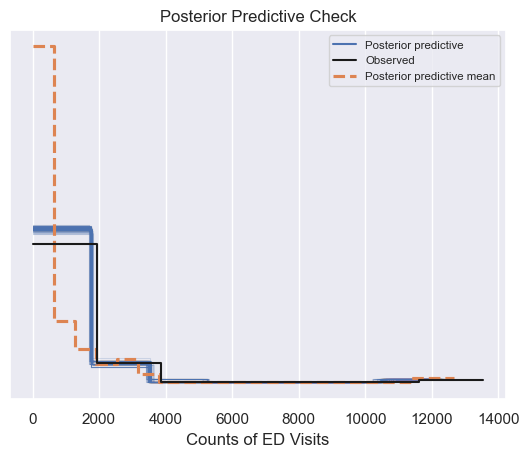

In [49]:
az.plot_ppc(ppc, num_pp_samples=100);
plt.title('Posterior Predictive Check');
plt.xlabel('Counts of ED Visits');

---

### Interpretations: Determining At-Risk Counties

Using the given counts, the top 5 counties with the emergency department (ed) visit rates of asthma are Solano, Lake, Merced, Fresno and Imperial.

In [50]:
cols = ['county', 'num_ed_visits', 'predicted_num_ed_visits', 'ed_visit_rate', 'predicted_ed_visit_rate']
full_dataset.sort_values(by='ed_visit_rate', ascending=False).head(5)[cols]

,county,num_ed_visits,predicted_num_ed_visits,ed_visit_rate,predicted_ed_visit_rate
47,Solano,917.625,846.058628,0.002077,0.001915
16,Lake,132.675,91.064779,0.002067,0.001419
23,Merced,550.425,480.699911,0.002028,0.001771
9,Fresno,1965.825,2090.355895,0.001997,0.002123
12,Imperial,336.250,236.951534,0.001861,0.001311


<br>

After training the Bayesian Hierarchical model, the top 5 counties with the emergency department (ed) visit rates are Fresno, Kings, Tulare, Solano and Merced.

In [51]:
full_dataset.sort_values(by='predicted_ed_visit_rate', ascending=False)[cols].head(5)

,county,num_ed_visits,predicted_num_ed_visits,ed_visit_rate,predicted_ed_visit_rate
9,Fresno,1965.825,2090.355895,0.001997,0.002123
15,Kings,264.525,312.387656,0.001755,0.002073
53,Tulare,513.500,947.199454,0.001112,0.002051
47,Solano,917.625,846.058628,0.002077,0.001915
23,Merced,550.425,480.699911,0.002028,0.001771


<br>

After creating a new column `rate_difference`, of the 5 counties with the largest absolute differences in ED visit rate between the hierarchical model estimates and the observed rate, none appear in the top 5 highest risk counties.

In [52]:
full_dataset['rate_difference'] = np.abs(full_dataset['predicted_ed_visit_rate'] - full_dataset['ed_visit_rate'])
full_dataset.sort_values(by='rate_difference', ascending=True)[cols].head()

,county,num_ed_visits,predicted_num_ed_visits,ed_visit_rate,predicted_ed_visit_rate
49,Stanislaus,814.125,812.421529,0.001499,0.001496
55,Ventura,718.750,711.003528,0.000848,0.000839
32,Riverside,2639.700,2598.870843,0.001095,0.001078
39,San Luis Obispo,219.850,224.772593,0.000779,0.000797
52,Trinity,14.525,14.015161,0.001144,0.001104


<br>

Similarly, after creating a new column `count_difference`, the bayesian hierarchical model predicted that San Diego, Orange, Tulare, San Mateo and Santa Clara counties will have more ED visits due to asthma.

In [53]:
full_dataset['count_difference'] = full_dataset['predicted_num_ed_visits'] - full_dataset['num_ed_visits']
cols = ['county', 'num_ed_visits', 'predicted_num_ed_visits', 'count_difference']
full_dataset.sort_values('count_difference', ascending=False)[cols].head()

,county,num_ed_visits,predicted_num_ed_visits,count_difference
36,San Diego,2747.025,3459.632835,712.607835
29,Orange,2412.750,3063.385068,650.635068
53,Tulare,513.500,947.199454,433.699454
40,San Mateo,607.525,942.077051,334.552051
42,Santa Clara,1478.975,1765.566715,286.591715


<br>

---

### Conclusion


Effect of PM 2.5 and Ozone on probability of ED visit 
- The PM 2.5 coefficient of 0.143 and Ozone coefficient of -0.004 (provided from the model) indicate that PM 2.5 and Ozone alone do not have a meaningful affect on ED visit rates county-wide.
- This could likely be due to other factors that may affect county variations in ED visit rate, such as race, socioeconomic status, income, access to healthcare, access to health foods, degree of urbanization, degree of industralization and various other factors. Additionally, our model does not account for changes in season, time or extreme events (such as fires, oil flares, etc.) due to complexity and lack of data.


<br>
Risk based on Rates

- Observed: the top 5 at-risk counties are __Solano, Lake, Merced, Fresno and Imperial__.
- Bayesian Estimates: the top 5 at-risk counties are __Fresno, Kings, Tulare, Solano, Merced.__

<br>
Risk based on Counts

- Observed: the top 5 at-risk counties are __Los Angeles, San Bernardino, San Diego, Riverside, Sacramento__ 
- Bayesian Estimates: the top 5 at-risk counties are __Los Angeles, San Diego, Orange, Riverside, San Bernardino__

---

### Limitations

- __Data Availability__: Due to lack of data availability for other types of asthma rates and issues with data sparsity due to privacy issues (e.g. hospitalization rates, asthma mortality rate), this model uses Emergency Department (ED) visit rates to define counties that could be most at risk. Therefore, it assumes the ED visit rate is the best indicator of risk for public health officials to make decisions.

- __Seasonality/Temporal Trends__: The current Bayesian hierarchical model does not account for seasonal or temporal trends in asthma prevalence, PM 2.5 levels, ozone concentrations and county populations. 

- There could be other variables important for determining the prevalence of a county, such as the number of fires and various spatial covariates that are not accounted for. This is due to the main focus of our model determining the impact of PM 2.5 and Ozone on ED visits related to asthma.

- The asthma prevalence by county data grouped Alpine, Amador, Calaveras, Inyo, Mariposa, Mono, and Tuolumne together to provide an estimate.

- The current model aggregates PM 2.5 data to generate a county level average, which assumes an average PM 2.5 concentration over all the census tracts in a county. Certain neighborhoods and areas within a county are potentially more PM 2.5 concentrations due to proximity to sources and level of urbanization/industralization. 